In [8]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, hamming_loss, f1_score, precision_score, recall_score, classification_report
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Load training and validation datasets
train_df = pd.read_csv('train.csv')
val_df = pd.read_csv('val.csv')

# Handle missing values
train_df = train_df.dropna(subset=['book_details'])
val_df = val_df.dropna(subset=['book_details'])

# Memastikan bahwa label berada dalam format list
def convert_to_list(row):
    return [col for col in row.index if row[col] == 1]

train_df['genres'] = train_df[['Fantasy', 'Young Adult', 'Classics', 'Romance', 'Historical Fiction']].apply(convert_to_list, axis=1)
val_df['genres'] = val_df[['Fantasy', 'Young Adult', 'Classics', 'Romance', 'Historical Fiction']].apply(convert_to_list, axis=1)

# Feature and target
X_train = train_df['book_details']
y_train = train_df['genres'].tolist()
X_val = val_df['book_details']
y_val = val_df['genres'].tolist()

# TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)

# Binarize the labels
mlb = MultiLabelBinarizer()
y_train_bin = mlb.fit_transform(y_train)
y_val_bin = mlb.transform(y_val)

print("Classes:", mlb.classes_)


Classes: ['Classics' 'Fantasy' 'Historical Fiction' 'Romance' 'Young Adult']


#Base model

Validation Accuracy: 0.49
Hamming Loss: 0.14
F1-Score: 0.69
Precision: 0.79
Recall: 0.62


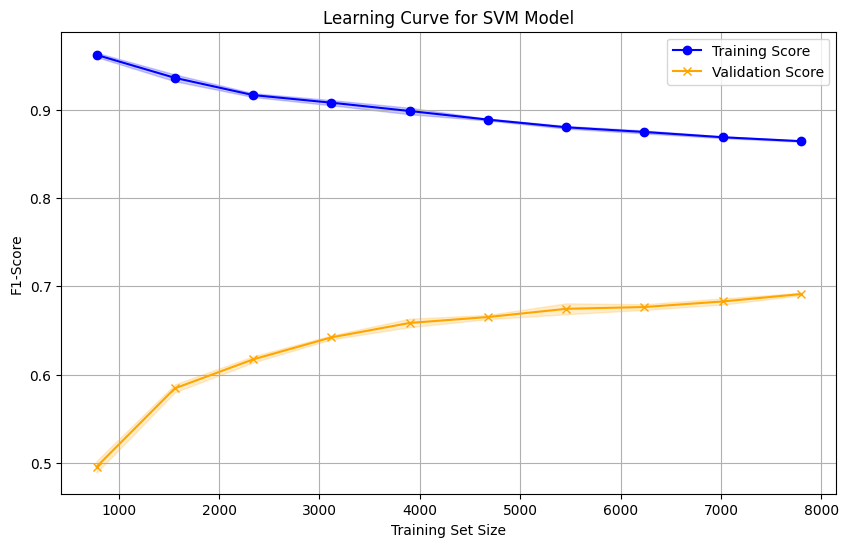

In [9]:
# Build the SVM model
svm_model = Pipeline([
    ('clf', OneVsRestClassifier(SVC(kernel='linear')))
])

# Fit the model
svm_model.fit(X_train_tfidf, y_train_bin)

# Predict on the validation set
y_pred_bin = svm_model.predict(X_val_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_val_bin, y_pred_bin)
hamming = hamming_loss(y_val_bin, y_pred_bin)
f1 = f1_score(y_val_bin, y_pred_bin, average='micro')
precision = precision_score(y_val_bin, y_pred_bin, average='micro')
recall = recall_score(y_val_bin, y_pred_bin, average='micro')

print(f"Validation Accuracy: {accuracy:.2f}")
print(f"Hamming Loss: {hamming:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

# Generate the learning curve
train_sizes, train_scores, val_scores = learning_curve(
    svm_model, X_train_tfidf, y_train_bin, cv=5, scoring='f1_micro', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate mean and standard deviation
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training Score', color='blue', marker='o')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
plt.plot(train_sizes, val_mean, label='Validation Score', color='orange', marker='x')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color='orange', alpha=0.2)

plt.title('Learning Curve for SVM Model')
plt.xlabel('Training Set Size')
plt.ylabel('F1-Score')
plt.legend(loc='best')
plt.grid()
plt.show()

#Tuning Hyperparameter Model

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END clf__estimator__C=0.1, clf__estimator__kernel=linear; total time= 1.5min
[CV] END clf__estimator__C=0.1, clf__estimator__kernel=linear; total time= 1.5min
[CV] END clf__estimator__C=0.1, clf__estimator__kernel=linear; total time= 1.5min
[CV] END ..clf__estimator__C=0.1, clf__estimator__kernel=rbf; total time= 1.9min
[CV] END ..clf__estimator__C=0.1, clf__estimator__kernel=rbf; total time= 1.9min
[CV] END ..clf__estimator__C=0.1, clf__estimator__kernel=rbf; total time= 1.9min
[CV] END .clf__estimator__C=1, clf__estimator__kernel=linear; total time= 1.3min
[CV] END .clf__estimator__C=1, clf__estimator__kernel=linear; total time= 1.3min
[CV] END .clf__estimator__C=1, clf__estimator__kernel=linear; total time= 1.2min
[CV] END ....clf__estimator__C=1, clf__estimator__kernel=rbf; total time= 2.0min
[CV] END ....clf__estimator__C=1, clf__estimator__kernel=rbf; total time= 2.0min
[CV] END ....clf__estimator__C=1, clf__estimat

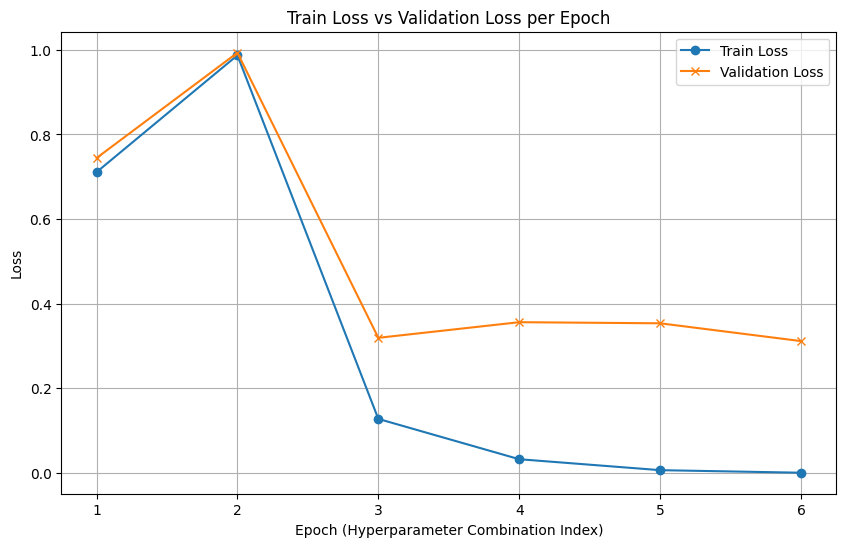

In [4]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'clf__estimator__C': [0.1, 1, 10],  # Regularization parameter
    'clf__estimator__kernel': ['linear', 'rbf'],  # Kernel type
}

# Wrap the model with GridSearchCV
grid_search = GridSearchCV(
    svm_model,
    param_grid,
    cv=3,  # 3-fold cross-validation
    scoring='f1_micro',  # Use F1-micro as the scoring metric
    verbose=2,
    return_train_score=True
)

# Fit GridSearchCV to the training data
grid_search.fit(X_train_tfidf, y_train_bin)

# Print the best parameters and the corresponding score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best F1-Score: {grid_search.best_score_:.2f}")

# Use the best model for further predictions
best_model = grid_search.best_estimator_

# Use the best model for predictions
y_pred_bin_best = best_model.predict(X_val_tfidf)

# Evaluate the model with the best hyperparameters
accuracy_best = accuracy_score(y_val_bin, y_pred_bin_best)
hamming_best = hamming_loss(y_val_bin, y_pred_bin_best)
f1_best = f1_score(y_val_bin, y_pred_bin_best, average='micro')
precision_best = precision_score(y_val_bin, y_pred_bin_best, average='micro')
recall_best = recall_score(y_val_bin, y_pred_bin_best, average='micro')

# Print evaluation metrics
print(f"Best Model Validation Accuracy: {accuracy_best:.2f}")
print(f"Best Model Hamming Loss: {hamming_best:.2f}")
print(f"Best Model F1-Score: {f1_best:.2f}")
print(f"Best Model Precision: {precision_best:.2f}")
print(f"Best Model Recall: {recall_best:.2f}")

# Extract train and validation losses
train_losses = 1 - grid_search.cv_results_['mean_train_score']
val_losses = 1 - grid_search.cv_results_['mean_test_score']

# Generate epoch numbers (assuming each combination as an epoch proxy)
epochs = np.arange(1, len(train_losses) + 1)

# Plot train vs validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='x')
plt.title('Train Loss vs Validation Loss per Epoch')
plt.xlabel('Epoch (Hyperparameter Combination Index)')
plt.ylabel('Loss')
plt.xticks(epochs)  # Ensure x-ticks match epochs
plt.legend()
plt.grid()
plt.show()